In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import os
import random
import shutil
import math
import sys

In [3]:
os.getcwd()

'/Users/adam/Jupyter/ML100Day'

In [4]:
os.listdir('./image_data/train')

['.DS_Store', 'daisy', 'rose', 'tulip', 'dandelion', 'sunflower']

In [27]:
train_dir = './image_data/train'
test_dir = './image_data/test'

In [3]:
# 讀取照片 - 方法一

DATASET_PATH = './image_data/train'

# Image preprocess

# 這邊已經標準化+切分訓練驗證資料 (0.7/0.3)
train_datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.125, height_shift_range=0.125, zoom_range=0.125, horizontal_flip=True,
                                   validation_split=0.3, rescale=1. / 255)
train_batches = train_datagen.flow_from_directory(DATASET_PATH, subset = 'training', seed = 1313)
valid_batches = train_datagen.flow_from_directory(DATASET_PATH, subset = 'validation', seed = 1313)
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Found 1978 images belonging to 5 classes.
Found 845 images belonging to 5 classes.
Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


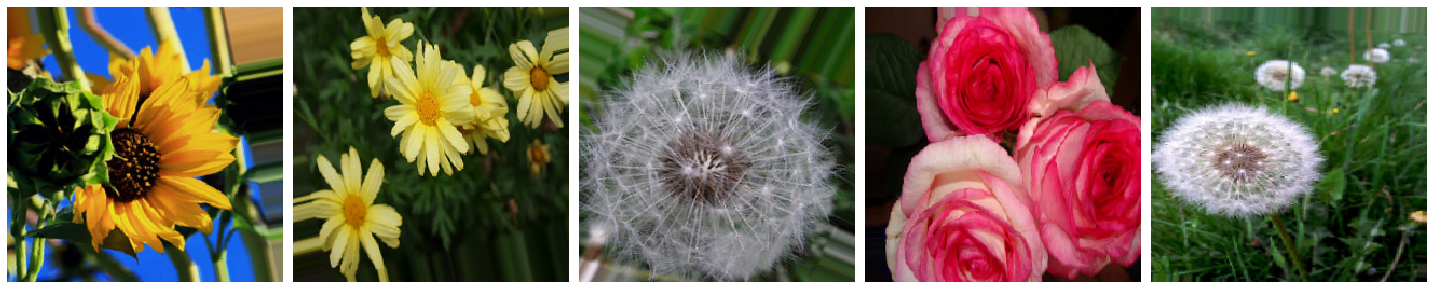

In [7]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_batches)
plotImages(sample_training_images[:5])

In [11]:
sample_training_images.shape[1:]

(256, 256, 3)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 196608)            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               100663808 
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)             

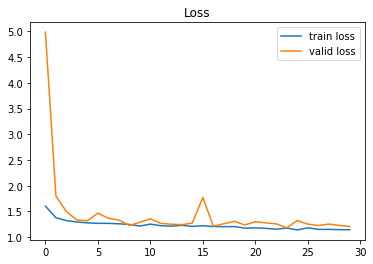

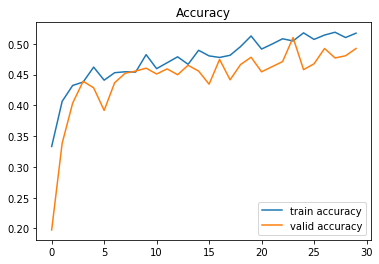

In [17]:
# A. 用最一般的DNN
"""
建立神經網路，並加入 BN layer
"""

def build_mlp(input_shape, output_units=5, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Flatten()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 30

model = build_mlp(input_shape=sample_training_images.shape[1:])
model.summary()
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit_generator(train_batches,
                        validation_data = valid_batches,epochs=EPOCHS)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]


import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [28]:
# 輸出test檔案 - 方法1 一個一個做
for testfile in os.listdir('./image_data/test'):
    filename = testfile.split('.')[0]
    img = image.load_img('./image_data/test'+'/'+testfile,target_size=(256, 256))
    if img is None:
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = x /255.
    pred = model.predict(x)[0]
    tof=np.argmax(pred)
    out = np.vstack((out,[filename, tof]))

pd.DataFrame(out).to_csv('./output'+'/Day101_prediction_DNN.csv',index=False,header=False)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_11 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
activation_12 (Activation)   (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 127, 127, 64)     

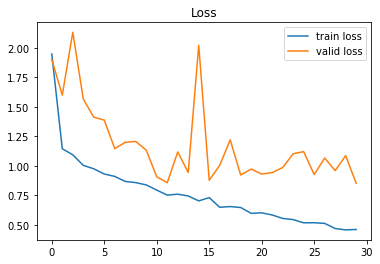

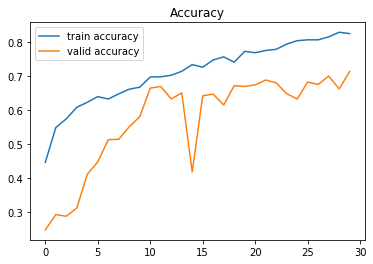

In [40]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=sample_training_images.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(5))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit_generator(train_batches,
                        validation_data = valid_batches,epochs=EPOCHS)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]


import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [45]:
# 輸出test檔案 - 方法1 一個一個做
out = np.array(['id', 'flower_class'])
for testfile in os.listdir('./image_data/test'):
    filename = testfile.split('.')[0]
    img = image.load_img('./image_data/test'+'/'+testfile,target_size=(256, 256))
    if img is None:
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = x /255.
    pred = model.predict(x)[0]
    tof=np.argmax(pred)
    out = np.vstack((out,[filename, tof]))

pd.DataFrame(out).to_csv('./output'+'/Day101_prediction_CNN_OLD.csv',index=False,header=False)

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
# Helper libraries
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import os
import cv2
import pandas as pd
import random
import shutil
import math

In [20]:
# 超參數設定

batch_size = 512
epochs = 65
data_augmentation = True
num_classes = 5

IMG_HEIGHT = 224
IMG_WIDTH = IMG_HEIGHT
input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

In [22]:


# from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet_v2 import preprocess_input
# from keras.applications.mobilenet_v2 import preprocess_input
# from keras.applications.vgg16 import preprocess_input

print('Using real-time data augmentation.')
datagen = dict(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=5,
    # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    # vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    # rescale=None,
    # rescale=1./255,
    # set function that will be applied on each input
    preprocessing_function=preprocess_input,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.3)

res_datagen = ImageDataGenerator(**datagen)

train_batches = res_datagen.flow_from_directory(DATASET_PATH,batch_size=128, subset = 'training', seed = 123)
valid_batches = res_datagen.flow_from_directory(DATASET_PATH,batch_size=128, subset = 'validation', seed = 123)
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Using real-time data augmentation.
Found 1978 images belonging to 5 classes.
Found 845 images belonging to 5 classes.
Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


In [9]:
# 使用resnet_v2 架構的模型 (include_top=False 代表不使用最後一層)

b_model = keras.applications.resnet_v2.ResNet50V2(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3))

# 架構主要 model

main_model = Sequential()
main_model.add(b_model)

# 想辦法讓訓練不要這麼飄
# main_model.add(BatchNormalization())
# main_model.add(Dense(2048, activation='relu'))
# main_model.add(BatchNormalization())
# main_model.add(Dense(1024, activation='relu'))
# main_model.add(BatchNormalization())
main_model.add(Dense(num_classes, activation='softmax'))

# 因為是遷移學習，本來就有訓練了，縮小 learning rate，才不會讓訓練好的成果跑掉
# opt = optimizers.SGD(lr=1e-4, momentum=0.9)
opt = optimizers.Adam(lr=0.0001)
# opt=optimizers.RMSprop(lr=1e-5)

main_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# 檢查是否凍結 ALL
print("--檢查 ALL 是否凍結-----------------")
for layer in main_model.layers:
    print(layer.name, ' is trainable? ', layer.trainable)

main_model.summary()

94674944/94668760 [==============================] - 26s 0us/step
--檢查 ALL 是否凍結-----------------
resnet50v2  is trainable?  True
dense  is trainable?  True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 23,529,605
Non-trainable params: 45,440
_________________________________________________________________


In [14]:
# 各種運用 callbacks

# 使用自動降低學習率 (當 validation loss 連續 5 次沒有下降時，自動降低學習率)
lr_reducer = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-14)

# 學習率動態調整。當跑到第幾個 epcoh 時，根據設定修改學習率。這邊的數值都是參考原 paper
def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 500:
        lr = 0.0000001
    elif epoch > 200:
        lr = 0.000001
    elif epoch > 100:
        lr = 0.00001
    print('Learning rate: ', lr)
    return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)


# checkpoint 儲存最好的一個

if not os.path.exists('best_loss'):
    os.makedirs('best_loss')

# tensorflow v2 val_acc -> val_accuracy
weight_path="./best_loss/epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}_val_loss_{val_loss:.4f}.h5"

ck_epoch_weight = keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          mode='min')


# 訓練提前結束，監控指標不再改變
# early = EarlyStopping(monitor="val_loss", 
#                       mode="min", 
#                       patience=10) 



# ----------- ReduceLROnPlateau -----------------
# keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
# monitor: 被監測的指標
# factor: 學習速率被降低的因數。新的學習速率 = 學習速率 * 因數
# patience: 沒有進步的訓練輪數，在這之後訓練速率會被降低。
# verbose: 整數。 0：安靜，1：更新信息。
# mode: {auto, min, max} 其中之一。如果是min 模式，學習速率會被降低如果被監測的數據已經停止下降； 在max 模式，學習速率會被降低如果被監測的數據已經停止上升； 在auto 模式，方向會被從被監測的數據中自動推斷出來。
# min_delta: 對於測量新的最優化的閥值，只關注巨大的改變。
# cooldown: 在學習速率被降低之後，重新恢復正常操作之前等待的訓練輪數量。
# min_lr: 學習速率的下邊界。

In [23]:
# 開始 training

# 設定 callbacks
callbacks = [ck_epoch_weight,lr_scheduler , lr_reducer]

history = main_model.fit_generator(
    train_batches,
    epochs=epochs,
    validation_data = valid_batches,
    callbacks=callbacks
)

Learning rate:  0.0001
Epoch 1/65
16/16 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8964 
Epoch 00001: val_loss improved from inf to 0.47549, saving model to ./best_loss/epoch_01_val_acc_0.8485_val_loss_0.4755.h5
16/16 [==============================] - 691s 43s/step - loss: 0.3136 - accuracy: 0.8964 - val_loss: 0.4755 - val_accuracy: 0.8485
Learning rate:  0.0001
Epoch 2/65
16/16 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.9348 
Epoch 00002: val_loss improved from 0.47549 to 0.39574, saving model to ./best_loss/epoch_02_val_acc_0.8746_val_loss_0.3957.h5
16/16 [==============================] - 727s 45s/step - loss: 0.1995 - accuracy: 0.9348 - val_loss: 0.3957 - val_accuracy: 0.8746
Learning rate:  0.0001
Epoch 3/65
16/16 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9702 
Epoch 00003: val_loss improved from 0.39574 to 0.35027, saving model to ./best_loss/epoch_03_val_acc_0.8899_val_loss_0.3503.h5
16/16 [

KeyboardInterrupt: 

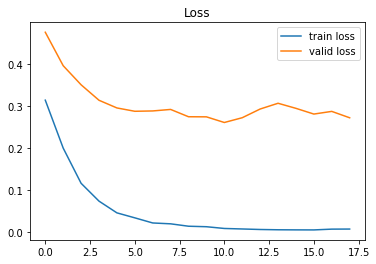

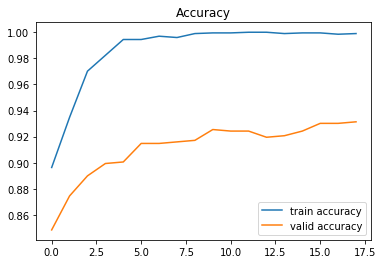

In [24]:
# Collect results
train_loss = main_model.history.history["loss"]
valid_loss = main_model.history.history["val_loss"]
train_acc = main_model.history.history["accuracy"]
valid_acc = main_model.history.history["val_accuracy"]


import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [29]:
# 比賽資料
datagen_pre = dict(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=5,
    # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    # vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    # rescale=None,
    # rescale=1./255,
    # set function that will be applied on each input
    preprocessing_function=preprocess_input,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0)


pred_flow = ImageDataGenerator(**datagen_pre).flow_from_directory(
    batch_size=128,
    directory='./image_data',
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=['test'],
    class_mode=None)

print("pred_flow.samples:", pred_flow.samples)
print("pred_flow.batch_size:", pred_flow.batch_size)

Found 2000 images belonging to 1 classes.
pred_flow.samples: 2000
pred_flow.batch_size: 128


In [30]:
# 預測結果
predictions = main_model.predict_generator(pred_flow, verbose=1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

Instructions for updating:
Please use Model.predict, which supports generators.
16/16 [==============================] - 78s 5s/step


In [31]:
# 輸出 CSV
import time
timestr = time.strftime("%Y%m%d_%H%M%S")
output_path = './output/Day101_bestRESTNETv2_{}.csv'.format(timestr)

get_file_name = lambda x: os.path.splitext(os.path.basename(x))[0]

pd_output_result = pd.DataFrame({'id': map(get_file_name, pred_flow.filenames), 'flower_class': predictions})
pd_output_result.to_csv(output_path, encoding='utf-8', index=False)

pd_output_result.head()

,id,flower_class
0,0028624c49b3e0610ff9f1d111f5d532,2
1,002c30700185b7971369258b438070d5,4
2,00852f4f666acecd0c0d140365b42efd,4
3,00c08828fce04e360c732cac01edad9e,4
4,00d366e7877b6a78b104b57d67b60e6b,4


# 讀取照片 - 方法二

# step 1: 讀取資料集, 並且 resize 圖片

# Set the path of the input folder 
train_path = './image_data/train'

os.listdir(train_path)

# Train and Test Set Variables
train_val_ratio = 0.3 # 70/30/ Data Split
train_dir = './data/train/'
val_dir = './data/val/'

file_names = ['dandelion', 'daisy', 'sunflower', 'rose', 'tulip']

#Remove Existing Folders if they exist
for folder in [train_dir, val_dir]:
    if os.path.exists(folder) and os.path.isdir(folder):
        shutil.rmtree(folder)

#Remake Category Folders in both Train and Test Folders
for category in file_names:
    # os.makedirs(test_folder + category)
    os.makedirs(train_dir + category)
    os.makedirs(val_dir + category)


#Split Data by Train Ratio and copy files to correct directory
for idx, category in enumerate(file_names):
    file_list = os.listdir(train_path + '/' + category)
    
    train_ratio = math.floor(len(file_list) * (1 - train_val_ratio))
    val_ratio = math.floor(len(file_list) * train_val_ratio)
    train_list = file_list[:train_ratio]
    val_list = file_list[train_ratio:train_ratio + val_ratio]
    
    for i, file in enumerate(train_list):
        shutil.copy(train_path + '/' + category + '/' + file, train_dir + '/' + category + '/' + file)
    sys.stdout.write('Moving %s train images to category folder %s' % (len(train_list), category))  
    sys.stdout.write('\n')
    for i, file in enumerate(val_list):
        shutil.copy(train_path + '/' + category + '/' + file, val_dir + '/' + category + '/' + file)
    sys.stdout.write('Moving %s validation images to category folder %s' % (len(val_list), category))                   
    sys.stdout.write('\n')
    
print("Done.")

# caculate images
print("統計資料集")
train_dir = './data/train/'
val_dir = './data/val/'

file_names = ['dandelion', 'daisy', 'sunflower', 'rose', 'tulip']

train_list = lambda name: os.path.join(train_dir, name)
val_list = lambda name: os.path.join(val_dir, name)


total_train = 0
total_val = 0

for name in file_names:
    num_tr = len(os.listdir(train_list(name)))
    total_train += num_tr
    print("-----class:"+name)
    print("train:", num_tr)
    num_val = len(os.listdir(val_list(name)))
    total_val += num_val
    print("val:", num_val)

print("-----Total:")
print("train:", total_train)
print("val:", total_val)